In [24]:
import pandas as pd
import numpy as np
import boto3

client = boto3.client('s3')
bucket='asdi-hackathon'
file_key = 'aq-sentinel/nitrogen-dioxide/no2_sentinel_01-16june.csv'
csv_obj = client.get_object(Bucket=bucket, Key=file_key)
obj = client.get_object(Bucket=bucket, Key=file_key)
df = pd.read_csv(obj['Body'])

#correct erroneous negative measurements, make positive
df['nitrogendioxide_tropospheric_column'] = abs(df['nitrogendioxide_tropospheric_column'])

In [25]:
df.head()

,nitrogendioxide_tropospheric_column,qa_value,time,layer,latitude,longitude
0,0.000054,0.74,2022-06-01,0.0,51.259598,0.292720
1,0.000112,0.74,2022-06-01,0.0,51.303303,0.252287
2,0.000101,0.74,2022-06-01,0.0,51.271698,0.059670
3,0.000149,0.74,2022-06-01,0.0,51.346848,0.211568
4,0.000138,0.74,2022-06-01,0.0,51.315163,0.018826


<AxesSubplot:>

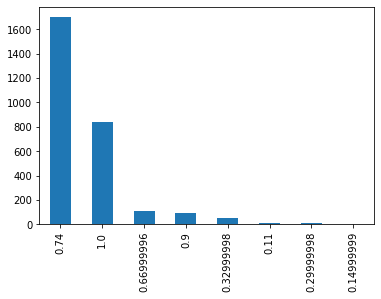

In [10]:
%matplotlib inline
df['qa_value'].value_counts().plot(kind = 'bar')

In [11]:
#problem with temporal variance in data smoothed by setting qa value, a lot of low quality recordings causing a lot of the variational disturbances
df = df[df['qa_value'] >= 1]   #0.9 for little more data or 1 for greatest quality measurements

In [12]:
import plotly.express as px

fig = px.scatter_mapbox(df, 
                        lat='latitude', 
                        lon='longitude',
                        color = 'nitrogendioxide_tropospheric_column',
                        center=dict(lat=51.5072, lon=0.1276), zoom=8,
                        mapbox_style="carto-darkmatter",
                        opacity = 0.5,
                        color_continuous_scale=px.colors.sequential.RdBu)

fig.show()

In [13]:
#haversine requires latitude and longitude in radians
import math
df['latitude'] = df['latitude'].apply(math.radians)
df['longitude'] = df['longitude'].apply(math.radians)

In [14]:
!pip3 install tqdm --quiet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

df_train, df_test = train_test_split(df, random_state = 0, test_size = 0.01)

X_train = df_train[['latitude', 'longitude']]
y_train = df_train['nitrogendioxide_tropospheric_column'].ravel()
X_test = df_test[['latitude', 'longitude']]
y_test = df_test['nitrogendioxide_tropospheric_column'].ravel()

#X = df[['latitude', 'longitude']]
#y = df['nitrogendioxide_tropospheric_column'].ravel()

k_range = range(1, 200)
k_scores = []

#uses 1 data point taken out as validation set with rest used for training
cv = LeaveOneOut()

from tqdm import tqdm
for k in tqdm(k_range):
    model = KNeighborsRegressor(n_neighbors=k, weights = 'distance', algorithm = 'brute', metric = 'haversine', n_jobs = -1)
    loss = abs(cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error', n_jobs = -1))
    k_scores.append(loss.mean())

model.fit(X_train, y_train)

100%|██████████| 199/199 [02:15<00:00,  1.47it/s]


KNeighborsRegressor(algorithm='brute', metric='haversine', n_jobs=-1,
                    n_neighbors=199, weights='distance')

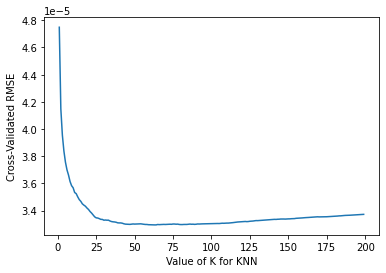

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated RMSE')
plt.show()

In [16]:
y_pred = model.predict(X_test)
results = pd.DataFrame(dtype = 'object')
results['y_test'] = y_test
results['y_pred'] = y_pred
results['difference'] = y_test - y_pred
results['abs_diff'] = abs(y_test - y_pred)
results.head()

,y_test,y_pred,difference,abs_diff
0,0.000046,0.000078,-0.000032,0.000032
1,0.000142,0.000101,0.000041,0.000041
2,0.000043,0.000081,-0.000039,0.000039
3,0.000235,0.000078,0.000157,0.000157
4,0.000050,0.000077,-0.000027,0.000027


In [17]:
results.describe()

,y_test,y_pred,difference,abs_diff
count,9.000000,9.000000,9.000000,9.000000
mean,0.000088,0.000085,0.000003,0.000044
std,0.000065,0.000011,0.000064,0.000044
min,0.000035,0.000072,-0.000044,0.000005
25%,0.000046,0.000078,-0.000034,0.000027
50%,0.000064,0.000079,-0.000027,0.000034
75%,0.000110,0.000097,0.000013,0.000041
max,0.000235,0.000101,0.000157,0.000157


<AxesSubplot:>

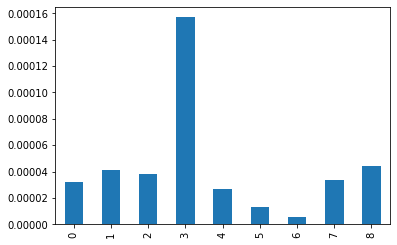

In [18]:
results['abs_diff'].plot.bar()

In [19]:
df['nitrogendioxide_tropospheric_column'].describe()

count    8.370000e+02
mean     8.610335e-05
std      4.835918e-05
min      4.698745e-07
25%      5.052772e-05
50%      7.584157e-05
75%      1.106895e-04
max      2.725943e-04
Name: nitrogendioxide_tropospheric_column, dtype: float64

In [20]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state = 0, test_size = 0.01)

X_train = df_train[['latitude', 'longitude']]
y_train = df_train['nitrogendioxide_tropospheric_column'].ravel()
X_test = df_test[['latitude', 'longitude']]
y_test = df_test['nitrogendioxide_tropospheric_column'].ravel()

#X = df[['latitude', 'longitude']]
#y = df['nitrogendioxide_tropospheric_column'].ravel()

cv = LeaveOneOut()

parameters = {'n_neighbors': np.arange(start=1, stop=200, step=2)}
grid_search = GridSearchCV(KNeighborsRegressor(weights = 'distance', algorithm = 'brute', metric = 'haversine'), 
                           param_grid = parameters, 
                           scoring='neg_root_mean_squared_error', 
                           n_jobs = -1,
                           cv = cv,
                           error_score = 'raise')
grid_search.fit(X_train, y_train)

print('best parameter(s): ', grid_search.best_params_)
print('best score(s): ', grid_search.best_score_)

best parameter(s):  {'n_neighbors': 61}
best score(s):  -3.294490254103525e-05


In [21]:
#use all of data in train
X_train = df[['latitude', 'longitude']]
y_train = df['nitrogendioxide_tropospheric_column'].ravel()

#use best k value
k = grid_search.best_params_['n_neighbors']
model = KNeighborsRegressor(n_neighbors=k, weights = 'distance', algorithm = 'brute', metric = 'haversine', n_jobs = -1)
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='brute', metric='haversine', n_jobs=-1,
                    n_neighbors=61, weights='distance')

In [22]:
import sys
import pathlib

ROOT = pathlib.Path().absolute().parent.as_posix()
if ROOT not in sys.path:
    sys.path.append(ROOT)

#pickle final model
import pickle
filename = ROOT + '/Pickles/no2_model.pkl'
model = model
pickle.dump(model, open(filename, 'wb'))